# Install Data & Packages

In [5]:
!pip install statsmodels --quiet

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
import os
import statsmodels as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
try:
    import statsmodels.api.add_constant
except ImportError:
    pass

Import Data.

In [7]:
path_data = '/content/data.csv' #edit path as necessary

# Check if files exist before loading
if os.path.exists(path_data):
    data = pd.read_csv(path_data)
    print("Data loaded successfully.")
else:
    print("Error: One or both files not found. Check the file paths.")

y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

Data loaded successfully.


# Least Absolute Shrinkage & Selection Operator (LASSO)

Lasso (Least Absolute Shrinkage and Selection Operator) regression utilizes L1 regularization, which adds a penalty proportional to the absolute values of the model's coefficients. This penalty encourages sparsity, effectively shrinking less important feature coefficients towards zero. As a result, Lasso performs feature selection by setting the coefficients of insignificant features to exactly zero, thus removing them from the model. This leads to a simpler, more interpretable model, especially useful in high-dimensional datasets where only a subset of features are expected to be relevant. Unlike Ridge regression, which only shrinks coefficients without eliminating them, Lasso's ability to produce sparse models makes it a powerful tool for both regularization and feature selection.

In [11]:
y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

colnames = X.columns

#Loading data
Y = y.to_numpy()
X = X.to_numpy()

# Center data
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

Methods to tune hyperparameter include K-Fold Cross-Validation, Bayesian Information Criterion (BIC), Regularization Path (Pathwise Coordinate Descent), etc.  However, for now we are using LASSO for feature selection and are not searching for an optimal model yet just interested in the feature selection properties of the l1 regularization.  Therefore, we will pick a penalty value at our discretion using the following guidelines.
*   If you are seeing a large number of variables (e.g., 50 out of 100) still retained in the model, it might indicate that the alpha value is too small (not applying enough regularization).
*   If only a small fraction of variables remain non-zero (e.g., 5-10 variables out of 100), this could indicate that the alpha value is too large, possibly over-penalizing the model.

## Fit Model

In [47]:
# Fit OLS
fit0 = LinearRegression()
fit0.fit(X_standardized, Y_centered)

# Fit LASSO
l1_penalty = 0.01 ###### alpha = 1.0 is default penalty, so it must be specified
lasso = Lasso(alpha = l1_penalty , fit_intercept=False)
lasso.fit(X_standardized, Y_centered)


# Ensure all arrays have the same shape
colnames = np.array(colnames)  # Convert to NumPy array
ols_coefs = fit0.coef_.flatten()  # Ensure it's 1D
lasso_coefs = lasso.coef_.flatten()  # Ensure it's 1D

# Stack into a DataFrame
lasso_df = pd.DataFrame({
    "Variables": colnames,
    "Without L1": ols_coefs,
    "With L1": lasso_coefs
})

print(f"LASSO shrinks {lasso_df.loc[abs(lasso_df['With L1']) == 0.0].shape[0]} coefficients to zero, i.e., there are {lasso_df.loc[abs(lasso_df['With L1']) != 0.0].shape[0]} nonzero coefficients.")
print(f"\nThe nonzero variables are printed below:\n")

LASSO_vars = list(lasso_df.loc[abs(lasso_df['With L1']) != 0.0]['Variables'].values)
LASSO_vars

LASSO shrinks 87 coefficients to zero, i.e., there are 13 nonzero coefficients.

The nonzero variables are printed below:



['racepctblack',
 'racePctWhite',
 'pctUrban',
 'MalePctDivorce',
 'PctKids2Par',
 'PctWorkMom',
 'PctIlleg',
 'PctPersDenseHous',
 'HousVacant',
 'PctHousOccup',
 'PctVacantBoarded',
 'NumStreet',
 'LemasPctOfficDrugUn']

Dropping from 100 variables to 13 with L1 regularization (λ = 0.01) suggests that 0.01 is not too small—it's actually strong enough to induce substantial sparsity. This means that many coefficients were forced to zero, leaving only 13 important features.  Therefore, we can naively (naive because out l1 regularization is suboptimal - should be picked according to some evaluation criteria such as MSE) attain the features that LASSO selects as significant (and compare to other methods such as SFS or best subsets).

##Regularization Path

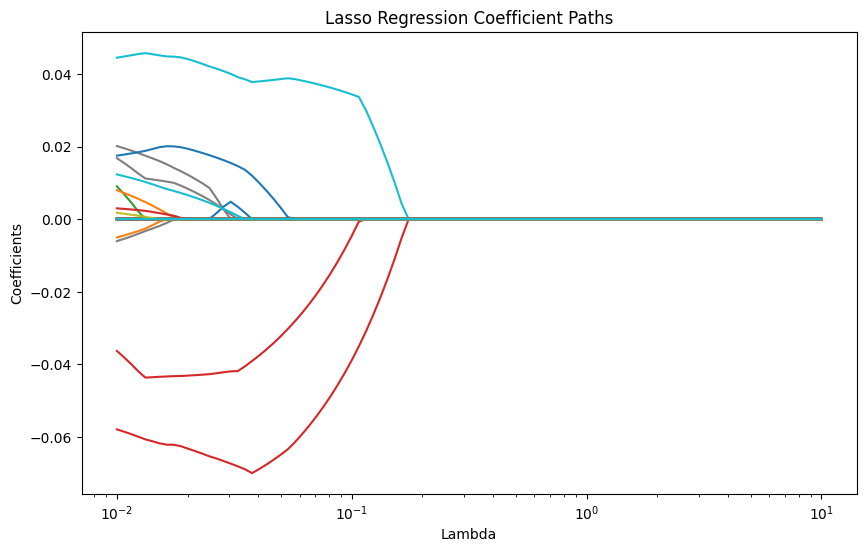

In [49]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasl = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    lasso = Lasso(alpha = lamb)
    lasso.fit(X_standardized, Y_centered)
    betasl[i, :] = lasso.coef_

# Plot Lasso paths (log-scale)
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Regression Coefficient Paths")
#legend is not relevant due to too many features to differentiate between.
# plt.legend(fontsize=1.8, loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

# Ridge

## Fit Model

In [74]:
y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

colnames = X.columns
n = X.shape[0]

#Loading data
Y = y.to_numpy()
X = X.to_numpy()

# Center data
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

In [75]:
l2_penalty = 1
ridge = Ridge(alpha=l2_penalty, fit_intercept=False)
ridge.fit(X_standardized, Y_centered)
beta = ridge.coef_
beta
pd.DataFrame({'Variables':colnames,'Coefficients':beta})

,Variables,Coefficients
0,population,0.013866
1,householdsize,-0.003173
2,racepctblack,0.051374
3,racePctWhite,-0.011992
4,racePctAsian,-0.002915
...,...,...
95,LandArea,0.002930
96,PopDens,-0.002136
97,PctUsePubTrans,-0.009801
98,LemasPctOfficDrugUn,0.006428


We can also do these calculations manually without packages (use this as a check).

In [76]:
beta_manual = np.linalg.inv(X_standardized.T @ X_standardized + np.diag([1] * X_standardized.shape[l2_penalty])) @ (X_standardized.T @ Y_centered)
assert (abs(beta_manual - beta) < 10**-5).all() == True, 'Error in Ridge Calculations'

## Regularization Path

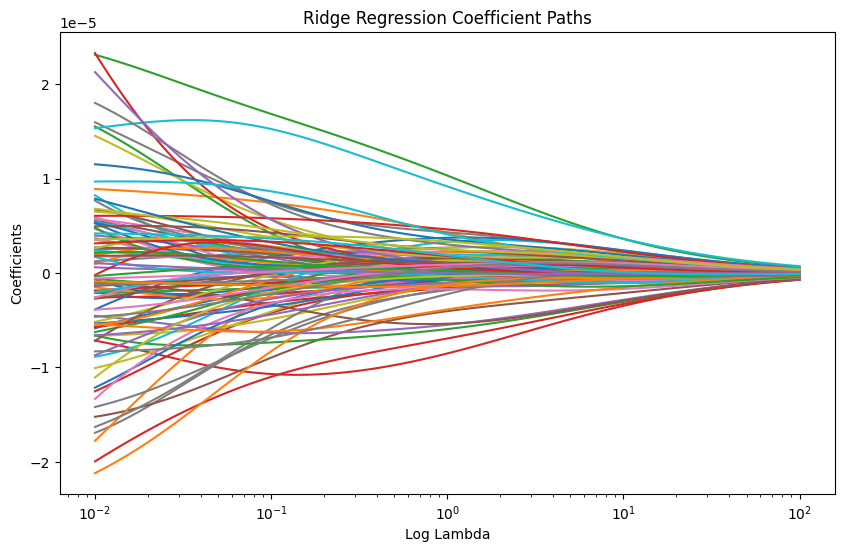

In [78]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(100), 100))
betasr = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    betasr[i, :] = np.linalg.inv(X_standardized.T @ X_standardized + np.diag([n*lamb] * X_standardized.shape[1])) @ (X_standardized.T @ Y_centered / n)

# Plot Ridge paths
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]):
    plt.plot(lambdas, betasr[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Log Lambda")
plt.ylabel("Coefficients")
plt.title("Ridge Regression Coefficient Paths")
# plt.legend(colnames)
plt.show()

Ridge regression (L2 regularization) and Lasso regression (L1 regularization) behave differently when handling correlated features. Ridge pulls correlated features toward each other, distributing the weight across them rather than eliminating any, leading to smooth but wavy regularization paths as coefficients adjust dynamically. In contrast, Lasso pushes one feature's coefficient to zero while keeping the other, performing feature selection and creating sharp changes in the regularization path. This fundamental difference explains why Ridge paths appear "squiggly", as correlated coefficients fluctuate together under increasing regularization strength.

# Elastic Net

## Fit Model

In [ ]:
# insert

## Regularization Path

In [ ]:
#insert